In [1]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import numpy as np
import nltk.corpus
import datetime
import string
import typing
import nltk
import time
import os
import io
%matplotlib inline

# disables tensorflow warnings 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorboard.plugins import projector
%load_ext tensorboard

tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(3)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
def load_region_data(region: str, language: str) -> pd.DataFrame:
    parquet_filename = os.path.join('./archive','{}-{}.parquet.gz'.format(region, language))
    if os.path.exists(parquet_filename):
        df = pd.read_parquet(parquet_filename)
        return df, df['category_id'].nunique()
    
    df = pd.read_csv('./archive/{}videos.csv'.format(region))

    # Drop unused columns
    df = df.drop(['thumbnail_link', 'video_id'], axis=1)
    df = df.dropna()

    # Enrich data
    df['publish_hour'] = pd.to_datetime(df['publish_time']).dt.hour
    df['comments_disabled'] = df['comments_disabled'].apply(lambda row: 0 if row == False else 1)
    df['ratings_disabled'] = df['ratings_disabled'].apply(lambda row: 0 if row == False else 1)
    df['video_error_or_removed'] = df['video_error_or_removed'].apply(lambda row: 0 if row == False else 1)
    df['like_dislike'] = df[['likes', 'dislikes']].apply(lambda row: row['likes'] / np.sum([row['likes'], row['dislikes']]), axis=1)
    df['tags'] = df['tags'].apply(lambda row: ' '.join( i.strip('""') for i in row.split('|') ))
    df['anti_participation'] = df[['comments_disabled', 'ratings_disabled']].apply(lambda row: row.sum(), axis=1)
    df['morning_video'] = df['publish_hour'].apply(lambda t: 1 if t <= 12 else 0)
    
    df = df.dropna()

    # Transform category_id to label
    category_le = sk.preprocessing.LabelEncoder()
    category_le.fit(df['category_id'])
    df['category_id'] = category_le.transform(df['category_id'])

    # Load stopwords
    try:
        stop_words = set(nltk.corpus.stopwords.words(language))
    except Exception:
        nltk.download('stopwords')
        stop_words = set(nltk.corpus.stopwords.words(language))
    
    # Drop stopwords
    df['tags'] = df['tags'].apply(lambda row: ' '.join(word for word in row.split() if word not in stop_words))
    df['description'] = df['description'].apply(lambda row: ' '.join(word for word in row.split() if word not in stop_words))
    
    views = df['views'].to_numpy().reshape((-1,1))
    view_scaler = sk.preprocessing.PowerTransformer()
    df['views'] = view_scaler.fit_transform(views)
    
    likes = df['likes'].to_numpy().reshape((-1,1))
    view_scaler = sk.preprocessing.StandardScaler()
    df['likes'] = view_scaler.fit_transform(likes)
    
    dislikes = df['dislikes'].to_numpy().reshape((-1,1))
    view_scaler = sk.preprocessing.StandardScaler()
    df['dislikes'] = view_scaler.fit_transform(dislikes)
    
    df.to_parquet(parquet_filename, compression='gzip')
    
    return df, len(category_le.classes_)

In [3]:
def create_xy(df: pd.DataFrame, feature: str) -> typing.Tuple[np.array, np.array]:
    X = df[feature].to_numpy()
    Y = df['category_id'].to_numpy().reshape((-1,1))
    
    return X, Y

In [4]:
vocab_size = 10000
sequence_length = 25

def create_model(X, num_classes, activation='softmax', lower=True):
    model = tf.keras.Sequential()
    
    vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=sequence_length,
        name='vectorize_layer',
    )

    vectorize_layer.adapt(X)

    model.add(vectorize_layer)
    model.add(tf.keras.layers.Embedding(vocab_size, 75,  name="embedding"))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=8, activation=activation))
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation=activation))
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=4, activation=activation))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(8))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(num_classes, activation='relu'))

    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['categorical_accuracy'],
    )
    
    return model

In [5]:
# Initialize history variables

def train_model(model, X, Y, n_splits=10, epochs=3):
    loss_history, accuracy_history = [[],[]], [[],[]]

    to_categorical = tf.keras.utils.to_categorical

    # tensorboard
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        embeddings_freq=1,
    )
    !rm -rf logs/

    # Kfold cross validation
    skf = sk.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True)
    for train_index, val_index in skf.split(X, Y):
        # Get train and test fold
        xtrain, xval = X[train_index], X[val_index]
    
        # We need to convert the Y to a categorical type in order for the 
        # multi-classifier to train and validate properly
        ytrain = to_categorical(Y[train_index], num_classes=num_classes)
        yval = to_categorical(Y[val_index], num_classes=num_classes)
    
        # Train and validate
        history = model.fit(xtrain, ytrain, validation_data=(xval, yval), verbose=0,
                            epochs=epochs, batch_size=128, callbacks=[tensorboard_callback])
    
        # Add values to training history
        loss_history[0].extend(history.history['val_loss'])
        loss_history[1].extend(history.history['loss'])
        accuracy_history[0].extend(history.history['val_categorical_accuracy'])
        accuracy_history[1].extend(history.history['categorical_accuracy'])
        
    return model, loss_history, accuracy_history, log_dir

In [6]:
def write_embedding_meta(model, log_dir):
    weights = model.get_layer('embedding').get_weights()[0]
    vocab = model.get_layer('vectorize_layer').get_vocabulary()

    metaf = io.open(os.path.join(log_dir, 'metadata.tsv'), 'w', encoding='utf-8')

    for index, word in enumerate(vocab):
        if index == 0: metaf.write('padding\n') # first is padding
        metaf.write(word + "\n")

    metaf.close()

In [7]:
def plot_val_loss(title, loss_history, accuracy_history):
    fig, axs = plt.subplots(2)
    axs[0].plot(loss_history[0], label='validation')
    axs[0].plot(loss_history[1], label='train')
    axs[0].set(title='Validation loss history', xlabel='No. split', ylabel='Loss value')
    axs[0].legend()

    axs[1].plot(accuracy_history[0], label='validation')
    axs[1].plot(accuracy_history[1], label='train')
    axs[1].set(title='Validation accuracy history', xlabel='No. split', ylabel='Accuracy value')
    axs[1].legend()

    fig.subtitle(title)
    fig.tight_layout()
    plt.show()

In [10]:
regions = [ ('US', 'english'), ('FR', 'french'), ('DE', 'german') ]
features = [ 'title', 'tags' ]

history = []
for region, language in regions:
    _region_start = time.time()
    for feature in features:
        region_df, num_classes = load_region_data(region, language)
        X, Y = create_xy(region_df, feature)
        for epoch in [1, 2]:
            for splits in [5, 6, 7, 8, 9, 10]:
                _model_start = time.time()
                model = create_model(X, num_classes)
                model, loss_history, accuracy_history, log_dir = train_model(model, X, Y)
                write_embedding_meta(model, log_dir)
                history.append([region, language, feature, epoch, splits, accuracy_history[0][-1]])
                print('model finished {} {} {} {} {} {:.2f}s'.format(
                    region, language, feature, epoch, splits, time.time() - _model_start))
        del X # help garbage collection
        del Y # RAM go brrrr
    print('finished region {} in {:2f} mins'.format(region, (time.time() - _region_start) / 60.))

history = pd.DataFrame(data=history, columns=['region', 'lang', 'feat', 'epochs', 'kfolds', 'accuracy'])
history.head()

model finished US english title 1 5 52.28s
model finished US english title 1 6 52.47s
model finished US english title 1 7 52.40s
model finished US english title 1 8 52.26s
model finished US english title 1 9 52.87s
model finished US english title 1 10 52.65s
model finished US english title 2 5 51.90s
model finished US english title 2 6 51.98s
model finished US english title 2 7 52.34s
model finished US english title 2 8 52.38s
model finished US english title 2 9 52.59s
model finished US english title 2 10 52.00s
model finished US english tags 1 5 55.88s
model finished US english tags 1 6 57.33s
model finished US english tags 1 7 56.53s
model finished US english tags 1 8 57.12s
model finished US english tags 1 9 57.26s
model finished US english tags 1 10 57.12s
model finished US english tags 2 5 57.00s
model finished US english tags 2 6 56.30s
model finished US english tags 2 7 56.17s
model finished US english tags 2 8 52.48s
model finished US english tags 2 9 52.62s
model finished US e

<ipython-input-2-80f0187a23f4>:18: RuntimeWarning: invalid value encountered in long_scalars
  df['like_dislike'] = df[['likes', 'dislikes']].apply(lambda row: row['likes'] / np.sum([row['likes'], row['dislikes']]), axis=1)
/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french title 1 5 45.67s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french title 1 6 45.19s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french title 1 7 44.47s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french title 1 8 44.05s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french title 1 9 45.94s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french title 1 10 46.60s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french title 2 5 45.28s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french title 2 6 44.62s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french title 2 7 44.34s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french title 2 8 46.73s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french title 2 9 47.25s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french title 2 10 45.79s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french tags 1 5 48.25s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french tags 1 6 47.96s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french tags 1 7 49.51s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french tags 1 8 49.20s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french tags 1 9 48.61s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french tags 1 10 48.21s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french tags 2 5 48.30s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french tags 2 6 48.69s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french tags 2 7 49.44s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french tags 2 8 48.85s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french tags 2 9 48.23s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished FR french tags 2 10 48.02s
finished region FR in 18.911241 mins


<ipython-input-2-80f0187a23f4>:18: RuntimeWarning: invalid value encountered in long_scalars
  df['like_dislike'] = df[['likes', 'dislikes']].apply(lambda row: row['likes'] / np.sum([row['likes'], row['dislikes']]), axis=1)
/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german title 1 5 50.49s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german title 1 6 49.14s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german title 1 7 48.33s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german title 1 8 48.03s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german title 1 9 50.58s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german title 1 10 50.05s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german title 2 5 49.13s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german title 2 6 48.41s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german title 2 7 48.46s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german title 2 8 49.60s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german title 2 9 51.76s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german title 2 10 50.35s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german tags 1 5 53.61s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german tags 1 6 52.58s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german tags 1 7 52.26s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german tags 1 8 53.41s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german tags 1 9 54.28s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german tags 1 10 52.36s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german tags 2 5 53.17s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german tags 2 6 52.96s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german tags 2 7 53.54s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german tags 2 8 54.71s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german tags 2 9 54.83s


/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


model finished DE german tags 2 10 53.97s
finished region DE in 20.701080 mins


,region,lang,feat,epochs,kfolds,accuracy
0,US,english,title,1,5,0.600995
1,US,english,title,1,6,0.591542
2,US,english,title,1,7,0.664677
3,US,english,title,1,8,0.545025
4,US,english,title,1,9,0.494279


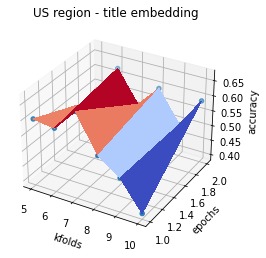

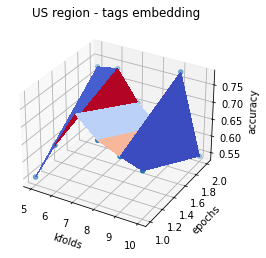

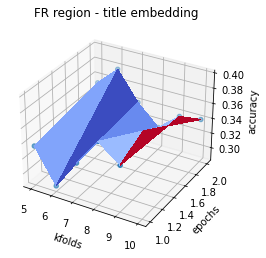

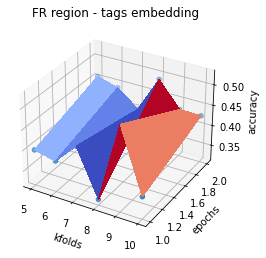

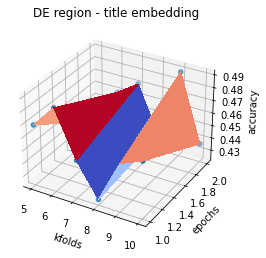

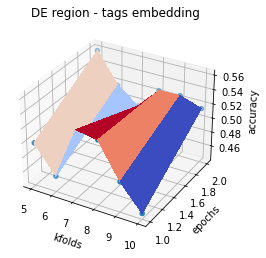

In [19]:
for region, _ in regions:
    for feat in features:
        df = history[history['region'] == region]
        df = df[df['feat'] == feat]
        
        Z = df.pivot_table(index='kfolds', columns='epochs', values='accuracy').T.values

        X_unique = np.sort(df['kfolds'].unique())
        Y_unique = np.sort(df['epochs'].unique())
        X, Y = np.meshgrid(X_unique, Y_unique)
    
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(df['kfolds'], df['epochs'], df['accuracy'])
        ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax.set(xlabel='kfolds', ylabel='epochs', zlabel='accuracy', title='{} region - {} embedding'.format(region, feat))
        plt.show()


In [16]:
history.head(50)

,region,lang,feat,epochs,kfolds,accuracy
0,US,english,title,1,5,0.600995
1,US,english,title,1,6,0.591542
2,US,english,title,1,7,0.664677
3,US,english,title,1,8,0.545025
4,US,english,title,1,9,0.494279
5,US,english,title,1,10,0.400249
6,US,english,title,2,5,0.499502
7,US,english,title,2,6,0.622139
8,US,english,title,2,7,0.518905
9,US,english,title,2,8,0.591791
